In [2]:
"""
Approximate CD Driving Solutions for Cycloguanil (ref: Iram, Dolson, Chiel et al. Nat Phys 2020)

Hinczewski Biotheory Group

@ Shamreen Iram,Michael Hinczewski

"""


from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import interpolate as inp
from scipy import optimize as op
import os, glob2,time

np.seterr(all='raise');

In [3]:
# Specify drive location with all input files needed to run this notebook 
# fitness landscape data+mutation matrix+ABM simulation output files
inputPath="./InputData"

In [4]:
os.getcwd()

'/Users/jakemarglous/DrivingWithHeat/CDDriving_PythonVersion'

In [5]:
# A: Definitions and Data Files

In [6]:
# A (i): 
# Loading mutation data matrix
# Recasting mutation matrix in required form mm:diagonal entries that make the columns sum zero 

mutdat=np.loadtxt(os.path.join(inputPath,"mut_matrix_.001.dat"),delimiter=',')
mm = np.transpose(mutdat)

for ii in range(mutdat.shape[0]):
    mm[ii,ii]=-(np.sum(mm[ii])-mm[ii,ii])

print(mm)

[[-0.001    0.00025  0.00025  0.       0.00025  0.       0.       0.
   0.00025  0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.00025 -0.001    0.       0.00025  0.       0.00025  0.       0.
   0.       0.00025  0.       0.       0.       0.       0.       0.     ]
 [ 0.00025  0.      -0.001    0.00025  0.       0.       0.00025  0.
   0.       0.       0.00025  0.       0.       0.       0.       0.     ]
 [ 0.       0.00025  0.00025 -0.001    0.       0.       0.       0.00025
   0.       0.       0.       0.00025  0.       0.       0.       0.     ]
 [ 0.00025  0.       0.       0.      -0.001    0.00025  0.00025  0.
   0.       0.       0.       0.       0.00025  0.       0.       0.     ]
 [ 0.       0.00025  0.       0.       0.00025 -0.001    0.       0.00025
   0.       0.       0.       0.       0.       0.00025  0.       0.     ]
 [ 0.       0.       0.00025  0.       0.00025  0.      -0.001    0.00025
   0.       0.       0.       0.       0.       0.  

In [7]:
# A (ii): 
# Defining g matrix: takes as input genotype frequency vector xv of length M-1, returns a M-1xM-1 matrix
# M= total no.of genotypes, i-th element xv_i=N_i/N_Tot,i!=WT

def g(xv) :
    x=15; 
    mut=np.zeros((x,x))
               
    for ii in range(x):
        for jj in range(x):
            if ii!=jj:
                mut[ii,jj]=-xv[ii]*xv[jj]
            else:
                mut[ii,jj]=xv[ii]*(1.0 - xv[ii])
    return mut

Text(0, 0.5, 'drug conc cc[t]')

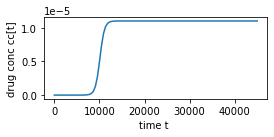

In [8]:
#A (iii): 
# Setting choice of dosage protocol cc(t)

def cc(t) :
    cct=0.000011/(1. + np.exp(-.002*(t - 10000 - 110)))
    return cct
                    
t = np.linspace(0,45000,100)
fig = plt.figure(figsize=(4,1.5))
plt.plot(t,cc(t))
plt.xlabel("time t ")
plt.ylabel("drug conc cc[t]")

In [9]:
# A (iv.i): 
# Defining selection coefficient s(t) using choice of dosage protocol and drug fitness seascape as input

drugless=np.loadtxt(os.path.join(inputPath,"untransformed_drugless_fitnesses.dat"),delimiter=',')
ic50 = np.loadtxt(os.path.join(inputPath,"cycloguanil_log_IC50s.dat"),delimiter=',')
cs = np.loadtxt(os.path.join(inputPath,"cycloguanil_cs.dat"),delimiter=',')

def sfc(conc,drugless,ic50,cs) :
    ut=np.zeros(len(cs))
    ut16 = drugless[15]/(1. + np.exp((ic50[15] - np.log10(conc))/cs[15]))
    for i in range(len(cs)):
        try:
            ut[i] = (drugless[i]/(1. + np.exp((ic50[i] - np.log10(conc))/cs[i])))/ut16 -1.
        except FloatingPointError:
            ut[i]=100000. 
        
    return ut

In [10]:
# A (iv.ii):  
# Exporting s(t) in input form needed for simulations s-> - s/(1+s)

ssim=[]
for i in range(0,45000):
    si=sfc(cc(i),drugless,ic50,cs)
    for j in range(16):
        try:
            si[j] = -si[j]/(1.+si[j])
        except FloatingPointError:
            si[j]=1.e7 
    ssim.append(si)

ssim.append(si)

In [11]:
print(np.shape(ssim))

(45001, 16)


In [12]:
ssim=np.asarray(ssim) 
np.savetxt("sCyc.csv", ssim, delimiter=",")

In [13]:
# A (v): 
# st=table of selection coefficients. Time entries row wise
# dst= st time derivatives
st=[]
for i in range(45001):
    st.append(sfc(cc(i),drugless,ic50,cs))
st=np.asarray(st) 
dst=np.diff(st, axis = 0)

In [14]:
print(np.shape(st))

print(st[0])
print(sum(st[0]))

np.savetxt("sCyc_orig.csv", st, delimiter = ",")

(45001, 16)
[ 0.11787381  0.0195518  -0.01831833 -1.          0.0954911   0.09937359
  0.11719567 -0.02488278 -0.10523504 -0.05298875  0.04473617 -0.20025398
  0.01801996  0.02549687  0.15954737  0.        ]
-0.7043925305896835


In [15]:
# A (vi): 
# Interpolating s(t) and ds(t)
# si[t,i]: Interpolation function for st[t,i]. t=time,i=genotype 
# dsi[t,i]: Interpolation function for dst[t,i]

si=[];dsi=[]
t = np.arange(0, 45001)
for i in range(16):
    ysi=st[:,i] 
    ydsi=dst[:,i]
    tck_si = inp.splrep(t, ysi,k=3,s=0) 
    tck_dsi = inp.splrep(t[1:,], ydsi,k=3,s=0) 
    ysin = inp.splev(t, tck_si, der=0)
    ydsin = inp.splev(t[1:,], tck_dsi, der=0)#
    si.append(ysin)
    dsi.append(ydsin)

si=np.transpose(np.asarray(si)) #putting time row wise
dsi=np.transpose(np.asarray(dsi))

In [16]:
print(np.shape(si))

(45001, 16)


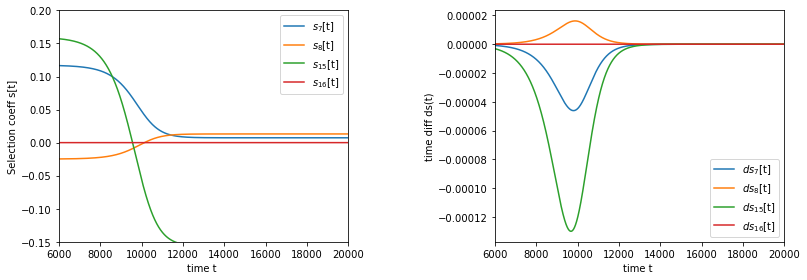

In [17]:
t = np.linspace(0,45000,45001)
dt =t[1:,]
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,si[:,6],t,si[:,7],t,si[:,14],t,si[:,15])
ax1.set_ylim([-0.15,0.2])
ax1.set_xlim([6000,20000])
ax1.set_xlabel("time t ")
ax1.set_ylabel("Selection coeff s[t]")
ax1.legend((r"$s_7$[t]","$s_8$[t]","$s_{15}$[t]","$s_{16}$[t]"))
ax2.plot(dt,dsi[:,6],dt,dsi[:,7],dt,dsi[:,14],dt,dsi[:,15])
ax2.set_xlim([6000,20000])
ax2.set_xlabel("time t ")
ax2.set_ylabel("time diff ds(t)")
ax2.legend((r"$ds_7$[t]","$ds_8$[t]","$ds_{15}$[t]","$ds_{16}$[t]"))
ratio = 0.8
for ax in [ax1,ax2]:
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_aspect(abs((xmax-xmin)/(ymax-ymin))*ratio, adjustable='box')

plt.tight_layout()
plt.savefig("orig_selectioncoeff.png")

In [18]:
print(np.sum(si[0]))
print(si[0])

-0.7043925305896837
[ 0.11787381  0.0195518  -0.01831833 -1.          0.0954911   0.09937359
  0.11719567 -0.02488278 -0.10523504 -0.05298875  0.04473617 -0.20025398
  0.01801996  0.02549687  0.15954737  0.        ]


In [19]:
#B Time evolution of IE genotype frequencies 

In [20]:
# B (i): 
# xeq0: Guess for mean genotype frequencies Xeq[t] at t0.  Needs to be somewhere in the vicinity of the 
# true answer as evident from s[t]. For Pyrimethamine: we know that genotype 15 dominates at t=0. So a choice of 
# x_16~<1 and small values for the others is a reasonable choice. 
xeq0=np.zeros(len(cs))
for i in range(len(cs)):
    if i == 14:
        xeq0[i]=0.96
    else:
        xeq0[i]=0.04/15.0
        
print(xeq0)
print(np.sum(xeq0))

[0.00266667 0.00266667 0.00266667 0.00266667 0.00266667 0.00266667
 0.00266667 0.00266667 0.00266667 0.00266667 0.00266667 0.00266667
 0.00266667 0.00266667 0.96       0.00266667]
1.0


In [21]:
# B (ii.i):
# Solving Eq. S39 from SI: Time evolution of mean IE genotype freq vector Xeq[t,i],i=genotype
# losseq: Takes as input time step and initial guess for Xeq[t] and returns loss func ~ R.H.S of Eq.S39  to
# solve for approximate Xeq[t,i]

def losseq(xg):  
    sM=np.diag(sv) 
    DM=np.identity(16)
    x = np.append(xg, 1.0-np.sum(xg))
    sv15 = sv[0:15] # Leaving out last element for dimensional compatibility
    T1 = np.dot(np.dot(mm,(DM+sM)),x)[0:15]
    T2 = np.dot(g(xg),sv15)
    return (T1 + T2)

In [22]:
# B (ii.ii):
# Solving Eq. S39 from SI: Time evolution of mean IE genotype freq vector Xeq[t,i],i=genotype
# Constructing numeric time series solutions for Xeq[t,i] using a root solver on losseq for t=0,20000
# By t= 20000 the Xeq[t,i] have converged to their final equilibrium values. So augmenting Xeq[t,i] from t=20000
# to t=45000 by appending Xeq[20000,i] many times.

Xeq=[]
xg=xeq0[0:15]
for t in range(0,45001,10):
    if t<=20000:
        sv = si[t]
        Xt = op.fsolve(losseq,xg)
        Xt=np.append(Xt,1.-np.sum(Xt))
        Xeq.append(Xt)
        xg=Xt[0:15]
    else:
        Xeq.append(Xeq[2000])        
Xeq=np.asarray(Xeq)

In [23]:
print(xeq0)
print(Xeq[0, :])
print(np.sum(Xeq[0, :]))

[0.00266667 0.00266667 0.00266667 0.00266667 0.00266667 0.00266667
 0.00266667 0.00266667 0.00266667 0.00266667 0.00266667 0.00266667
 0.00266667 0.00266667 0.96       0.00266667]
[3.54853236e-07 1.23764665e-09 1.42942174e-05 6.22669749e-09
 3.75581673e-05 2.53348215e-07 6.76131209e-03 1.26850068e-05
 4.40985675e-06 1.62217090e-08 2.49415055e-03 3.06066893e-06
 2.02339689e-03 7.19641820e-06 9.86846481e-01 1.79482337e-03]
0.9999999999999999


In [24]:
for i in range(Xeq.shape[0]):
    for j in range(Xeq.shape[1]):
        if Xeq[i, j] <= 0:
            print(i, j)


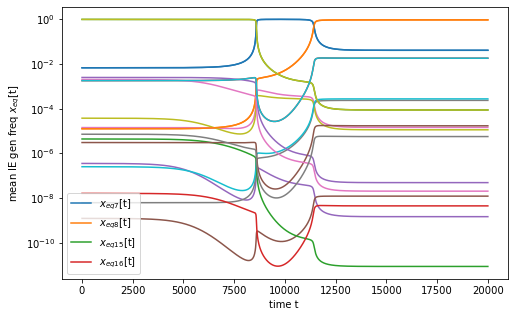

In [25]:
# B (ii.iii):
# Solving Eq. S39 from SI: Time evolution of mean IE genotype freq vector Xeq[t,i],i=genotype
# solution

t = np.linspace(0,20000,2000)
fig = plt.figure(figsize=(8,5))
plt.plot(t,Xeq[0:2000,6],t,Xeq[0:2000,7],t,Xeq[0:2000,14],t,Xeq[0:2000,15])
for i in range(16):
    plt.plot(t, Xeq[0:2000, i])
plt.yscale("log")
plt.xlabel("time t ")
plt.ylabel(r"mean IE gen freq $x_{eq}$[t]")
plt.legend((r"$x_{eq7}$[t]","$x_{eq8}$[t]","$x_{eq15}$[t]","$x_{eq16}$[t]"))

#plt.savefig("16genotypeCycSimWithMostly16Init.png")

Text(0.5, 1.0, '$x_{eq}$[t] vs x[t]: K=5e6')

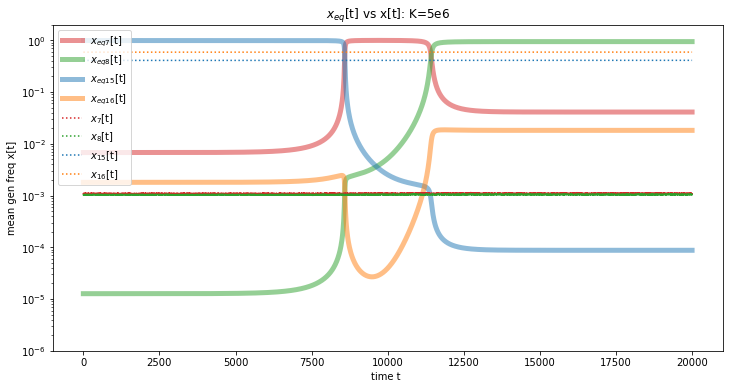

In [31]:
# B (iii):
# Visualizing lag between IE trajectory Xeq[t,i] and actual X[t,i] 
# X[t,i] = output from ABM simulations run with input ssim (from #A (iv.ii))

xSim=np.loadtxt(os.path.join(inputPath,"pop_propsCyc_5M.csv"),delimiter=',',skiprows=1)
pySim = np.loadtxt("../pySim_frac.csv", delimiter = ",")

py16sim = np.empty(20000)
for i in range(20000):
    x16sim[i]=1.-np.sum(xSim[i,1:16])
    t = np.linspace(0,20000,2000)
    
tSim = np.linspace(0,20000,20000)
fig = plt.figure(figsize=(12,6))
plt.plot(t,Xeq[0:2000,6],'#d62728',t,Xeq[0:2000,7],'#2ca02c',t,Xeq[0:2000,14],'#1f77b4',t,Xeq[0:2000,15],'#ff7f0e',alpha=0.5,lw=5)
#plt.plot(tSim,xSim[0:20000,7],'#d62728',tSim,xSim[0:20000,8],'#2ca02c',tSim,xSim[0:20000,15],'#1f77b4',tSim,x16sim[0:20000],'#ff7f0e',alpha=1,ls='dashed')
plt.plot(tSim,pySim[0:20000,6],'#d62728',tSim,pySim[0:20000,7],'#2ca02c',tSim,pySim[0:20000,14],'#1f77b4',tSim,pySim[0:20000, 15],'#ff7f0e',alpha=1,ls='dotted')

plt.yscale("log")
plt.xlabel("time t ")
plt.ylim([1e-6,2])
plt.ylabel("mean gen freq x[t]")
plt.legend((r"$x_{eq7}$[t]","$x_{eq8}$[t]","$x_{eq15}$[t]","$x_{eq16}$[t]","$x_{7}$[t]","$x_{8}$[t]","$x_{15}$[t]","$x_{16}$[t]", "$x_{7, py}$[t]", "$x_{8, py}$[t]", "$x_{15, py}$[t]", "$x_{16, py}$[t]"),loc="upper left")
plt.title(r"$x_{eq}$[t] vs x[t]: K=5e6")

#plt.savefig("simwithproperinit.png")

In [30]:
#C Time evolution under CD driving

In [32]:
# C (i):
# Constructing interpolation functions for Xeq[t,i] and time derivative of mean genotype frequencies dXeq[t,i].
# dXeq[t,i]= time derivative of Xeq[t,i] needed for calculating s_CD[t]
# Xeqi[t,i]: Interpolation function for Xeq[t,i] 
# dXeqi[t,i]: Interpolation function for dXeq[t,i]

dXeq=np.diff(Xeq, axis = 0)/10 

Xeqi=[];dXeqi=[]
t = np.arange(0, 45001,10)
for i in range(16):
    yXeqi=Xeq[:,i] 
    ydXeqi=dXeq[:,i]
    tck_Xeqi = inp.splrep(t, yXeqi,k=3,s=0) 
    tck_dXeqi = inp.splrep(t[1:], ydXeqi,k=3,s=0) 
    yXeqin = inp.splev(t, tck_Xeqi, der=0)
    ydXeqin = inp.splev(t[1:], tck_dXeqi, der=0)#
    Xeqi.append(yXeqin)
    dXeqi.append(ydXeqin)

Xeqi=np.transpose(np.asarray(Xeqi))
dXeqi=np.transpose(np.asarray(dXeqi))

In [33]:
# C (ii):
# Evaluating scd[t,i]= perturbation to take s(t)-> s_CD(t) (second term on R.H.S of Eq.4 of manuscript)


d=0.05 #ABM death rate, needed for ABM sim-WF mapping

scdt=[]; scdp=np.empty([4500,16])
for t in range(0,4500):
    scdi=np.zeros(16)
    for i in range(0,15):
        T1=(1.-np.sum(np.delete(Xeq[t,0:15],i)))*dXeq[t,i]
        T2=(np.sum(np.delete(dXeq[t,0:15],i)))*Xeq[t,i]
        T3=Xeq[t,i]*(1.-np.sum(Xeq[t,0:15]))
        scdi[i]=(1./d)*(T1+T2)/T3
        scdi[15]=0. #adding zero for wild type 
    scdt.append(scdi)
    
scdt=np.asarray(scdt)

In [35]:
# C (iii):
# Calculating selection coefficient CD protocol s_tilde(t)= scdp[t,i]
# scdi[t,i]=interpolation function for scdt[t,i]
# scdp[t,i] =[original s protocol + perturbation]= si[t,i]+scdi[t,i]
# Setting the most unfit genotypes to be -0.99 instead of -1 to prevent numerical issues. 


scdi=[];scdp=np.empty([45000,16]); ts = np.arange(0, 45000,10);t= np.arange(0, 45000)#dt=t[1:,]

for i in range(0,16):
    yscdi=scdt[:,i]
    tck_scdi = inp.splrep(ts, yscdi,k=3,s=0) 
    yscdin = inp.splev(t, tck_scdi, der=0)
    scdi.append(yscdin)
print(np.shape(scdi))

scdi=np.transpose(np.asarray(scdi))

print(np.shape(scdi))
print(np.shape(scdp))
for t in range(0,45000):
    scdp[t]=si[t]+scdi[t]
    for i in range(0,len(scdp[t])):
        scdp[t,i]=max(scdp[t,i], -0.99)

(16, 45000)
(45000, 16)
(45000, 16)


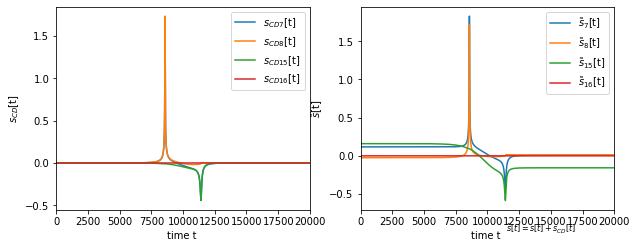

In [36]:
t = np.linspace(0,20000,20000)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,scdi[0:20000,6],t,scdi[0:20000,7],t,scdi[0:20000,14],t,scdi[0:20000,15])
ax1.set_xlim([0,20000])
ax1.set_xlabel("time t ")
ax1.set_ylabel(r"$s_{CD}$[t]")
ax1.legend((r"$s_{CD7}$[t]","$s_{CD8}$[t]","$s_{CD15}$[t]","$s_{CD16}$[t]"))
ax2.plot(t,scdp[0:20000,6],t,scdp[0:20000,7],t,scdp[0:20000,14],t,scdp[0:20000,15])
ax2.set_xlim([0,20000])
ax2.set_xlabel("time t ")
ax2.set_ylabel(r"$\tilde{s}$[t]")
ax2.legend((r"$\tilde{s}_7$[t]",r"$\tilde{s}_8$[t]",r"$\tilde{s}_{15}$[t]",r"$\tilde{s}_{16}$[t]"))
ax2.text(11500,-1,r"$\tilde{s}[t]=s[t]+s_{CD}[t]$",fontsize=8)
ratio = 0.8
for ax in [ax1,ax2]:
   xmin, xmax = ax.get_xlim()
   ymin, ymax = ax.get_ylim()
   ax.set_aspect(abs((xmax-xmin)/(ymax-ymin))*ratio, adjustable='box')

In [37]:
# C (iv):
# Estimating the approximate CD drug protocol ccv 
# Process: Find drug conc perturbation dcc= ccv -cc that minimizes  fminCD(conc) 
# fminCD(conc)= the R.H.S of Eq.S60.  


def fminCD(ccv): #input array: ccv[0]=t ccv[1]=ccv (CD drug perturbation)
    T1=((1./d)*dXeqi[i,0:15])
    T2=np.dot(g(Xeqi[i,0:15]),(sfc(ccv,drugless,ic50,cs)-si[t])[:15])
    return np.log10(np.sum(pow((T1-T2),2.)))

dcc=[];ccvg=np.empty(4500)
t=0;i = 0 #first value 
ccvg[0] = abs(op.fmin(fminCD,cc(0)+1e-15,disp=False))
dcc.append(ccvg[0]-cc(0))
for i in range(1,4500):
    t=i*10
    ccvg[i]=abs(op.fmin(fminCD,cc(t)+1.e-15,disp=False))
    dcc.append(ccvg[i]-cc(t))#guess value for ccv=cc +very small perturbation~10^-15
    
dcc=np.asarray(dcc)

In [38]:
# C (v): 
# Final CD drug conc protocol ccv=cc+dcc
# ccCD= interpolation ccv
# Realistic protocol: setting bound maxc on drug conc value (cannot kill patient!!)


ccv=np.empty([4500]); maxc = 0.01
for i in range(0,4500):
    t=i*10.
    ccv[i]=min(maxc,dcc[i]+cc(t))
ts = np.arange(0, 45000,10);t= np.arange(0, 45000)    
tck_ccvi = inp.splrep(ts,ccv,k=3,s=0) 
ccCD = inp.splev(t, tck_ccvi, der=0)

Text(0, 0.5, 'Drug conc')

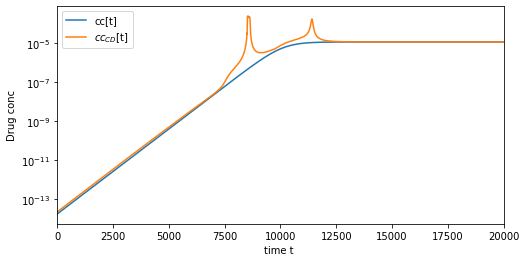

In [39]:
ts = np.arange(0,45000)
tM = np.arange(0,20000)
fig = plt.figure(figsize=(8,4))
plt.plot(ts,cc(ts),ts,ccCD)
plt.yscale("log")
plt.xlim(0,20000)
plt.legend((r"cc[t]",r"$cc_{CD}$[t]"))
plt.xlabel("time t ")
plt.ylabel(r"Drug conc")

In [40]:
# C (vi):
# Exporting CD sel coeff protocol in form needed for ABM code: s --> -s/1+s
sCDsim=[]
for i in range(0,45000):
    sCD=sfc(ccCD[i],drugless,ic50,cs)
    for j in range(16):
        try:
            sCD[j] = -sCD[j]/(1.+sCD[j])
        except FloatingPointError:
            sCD[j]=1.e7 
    sCDsim.append(sCD)

sCDsim.append(sCD)

In [41]:
sCDsim=np.asarray(sCDsim) 
np.savetxt("sCDCyc.csv", sCDsim, delimiter=",")

Text(0.5, 1.0, '$x_{eq}$[t] vs $x_{CD}$[t]: K=5e6')

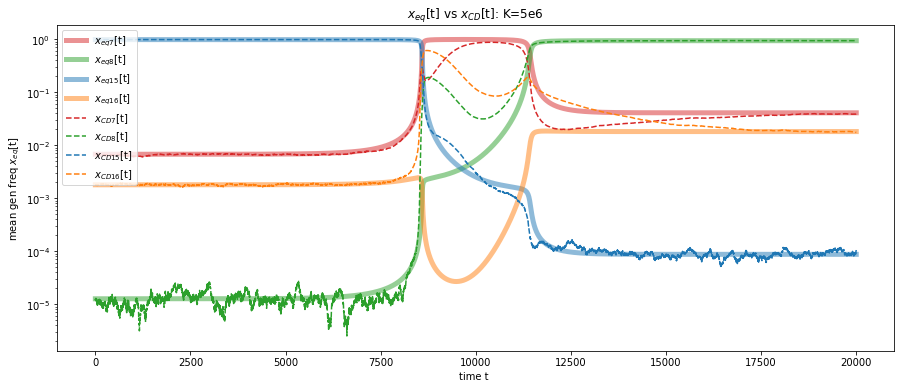

In [42]:
# C (vii):
# Visualizing IE trajectory Xeq[t,i] against CD driven actual X_CD[t,i] 
# X_CD[t,i] = output from ABM simulations run with input sCDsim (from #C (vi))

xSim=np.loadtxt(os.path.join(inputPath,"pop_propsCycCD_5M.csv"),delimiter=',',skiprows=1)

x16sim=np.empty(20000)
for i in range(20000):
    x16sim[i]=1.-np.sum(xSim[i,1:16])
    t = np.linspace(0,20000,2000)
    
t = np.linspace(0,20000,2000);tSim = np.linspace(0,20000,20000)
fig = plt.figure(figsize=(15,6))
plt.plot(t,Xeq[0:2000,6],'#d62728',t,Xeq[0:2000,7],'#2ca02c',t,Xeq[0:2000,14],'#1f77b4',t,Xeq[0:2000,15],'#ff7f0e',alpha=0.5,lw=5)
plt.plot(tSim,xSim[0:20000,7],'#d62728',tSim,xSim[0:20000,8],'#2ca02c',tSim,xSim[0:20000,15],'#1f77b4',tSim,x16sim[0:20000],'#ff7f0e',linestyle='dashed')
plt.yscale("log")
plt.xlabel("time t ")
plt.ylabel(r"mean gen freq $x_{eq}$[t]")
plt.legend((r"$x_{eq7}$[t]","$x_{eq8}$[t]","$x_{eq15}$[t]","$x_{eq16}$[t]","$x_{CD7}$[t]","$x_{CD8}$[t]","$x_{CD15}$[t]","$x_{CD16}$[t]"),loc="upper left")
plt.title(r"$x_{eq}$[t] vs $x_{CD}$[t]: K=5e6")